In [1]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
import inspect

top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from longestpath.gen import gen_num_edges, gen_num_edges_undirected, gen_planted_hamiltonian_undirected_fixed_degree
from benchmarking import RandomParams, Benchmark, new_random_benchmark, Solver, new_graph_file_benchmark, new_benchmark
import re

In [51]:
def generate():
  return [
    gen_planted_hamiltonian_undirected_fixed_degree(30, round(30 * deg / 2))
    for deg in np.linspace(1.0, 10.0, 10) for _ in range(1)
  ]
	# return [
	# 	gen_planted_hamiltonian_undirected_fixed_degree(round(verts), round(verts * 8 / 2))
	# 	for verts in np.linspace(10, 30, 10) for _ in range(5)
	# ]

params_code = inspect.getsource(generate)
graphs = generate()

benchmark = new_benchmark(graphs, solvers=[
	# Solver("brute", "FAST_BOUND"),
	# Solver("brute", "BRUTE_FORCE"),
	# Solver("brute", "BRANCH_N_BOUND"),
	# Solver("brute", "BRUTE_FORCE_COMPLETE"),
	# Solver("ilp"),
	# Solver("kalp", threads=4),
	Solver("kalp"),
], params_code = params_code, override_benchmark_path="../benchmarks/ham_test")

benchmark.benchmark_path


'../benchmarks/ham_test(31)'

In [38]:
np.linspace(10, 30, 10)

array([10.        , 12.22222222, 14.44444444, 16.66666667, 18.88888889,
       21.11111111, 23.33333333, 25.55555556, 27.77777778, 30.        ])

In [41]:
benchmark = Benchmark.load("../benchmarks/ham_test(25)")

In [52]:
benchmark.run(retryFailures=True, timeout=5)


graph: 0.txt, solver: kalp() ... ham!
✅
length: 29, run_time: 1.8324573222344043
graph: 1.txt, solver: kalp() ... ham!
✅
length: 29, run_time: 1.4871613950526807
graph: 2.txt, solver: kalp() ... ham!
✅
length: 29, run_time: 1.4474245070741745
graph: 3.txt, solver: kalp() ... ham!
✅
length: 29, run_time: 1.430120398159488
graph: 4.txt, solver: kalp() ... ham!
✅
length: 29, run_time: 1.3805809451441746
graph: 5.txt, solver: kalp() ... ham!
✅
length: 29, run_time: 1.4463591759849805
graph: 6.txt, solver: kalp() ... ham!
✅
length: 29, run_time: 1.5505605539656244
graph: 7.txt, solver: kalp() ... ham!
✅
length: 29, run_time: 1.6030170850426657
graph: 8.txt, solver: kalp() ... ham!
✅
length: 29, run_time: 1.4930387959029758
graph: 9.txt, solver: kalp() ... ham!
✅
length: 29, run_time: 1.6930174350127345
graph: 10.txt, solver: kalp() ... ham!
✅
length: 29, run_time: 2.7221562399790855
graph: 11.txt, solver: kalp() ... ham!
✅
length: 29, run_time: 3.617872122937115
graph: 12.txt, solver: kalp(

SystemExit: 130

/home/rob/.pyenv/versions/3.10.13/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [44]:
df_ = benchmark.get_dataframe()
if not "failure" in df_:
    df_["failure"] = None
df = df_
df.head()

,path,run_time,length,solver,graph_id,failure,solver_name,vertices,edges,average_out_degree
0,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 1]",0.009039,9.0,0,0,NaN,kalp(),10,80,8.0
1,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 1]",0.010531,9.0,0,1,NaN,kalp(),10,80,8.0
2,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 1]",0.007953,9.0,0,2,NaN,kalp(),10,80,8.0
3,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 1]",0.006585,9.0,0,3,NaN,kalp(),10,80,8.0
4,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 1]",0.008789,9.0,0,4,NaN,kalp(),10,80,8.0


run_time    Axes(0.125,0.11;0.775x0.77)
dtype: object

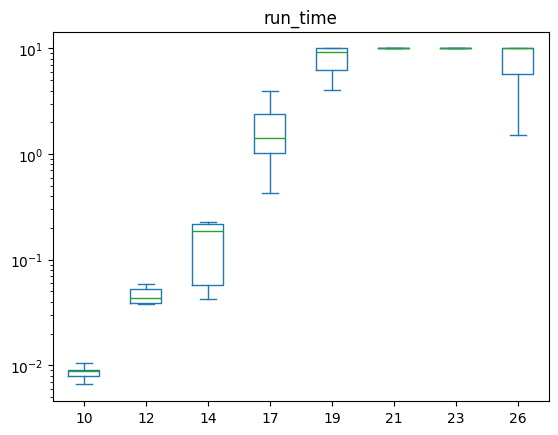

In [45]:
df[df["solver"] == 0][["run_time", "vertices"]].plot.box(by="vertices", logy=True)


In [46]:
df_grouped = df.groupby(['vertices', 'solver', 'solver_name']).agg({"run_time": "median", "failure": "any"}).reset_index()
df_grouped_failures_removed = df_grouped[df_grouped["failure"] == False]
to_plot = df_grouped_failures_removed.pivot(index='vertices', columns='solver_name', values='run_time').rename(columns=lambda x: x + " (average)")

In [47]:
df_grouped_failures_removed.groupby(["solver_name"]).agg({"failure": "count"}).reset_index().rename(columns={"failure": "count"})

,solver_name,count
0,kalp(),4


In [48]:
df_grouped_failures_removed.head()

,vertices,solver,solver_name,run_time,failure
0,10,0,kalp(),0.008789,False
1,12,0,kalp(),0.043127,False
2,14,0,kalp(),0.186873,False
3,17,0,kalp(),1.424587,False


In [49]:
to_plot


solver_name,kalp() (average)
vertices,
10,0.008789
12,0.043127
14,0.186873
17,1.424587


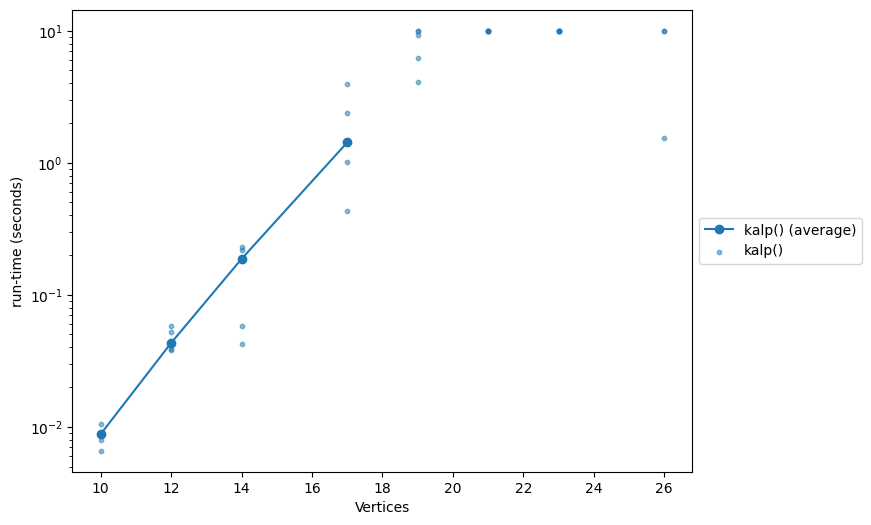

In [50]:
view = df[['vertices', 'solver_name','length', 'run_time']]

# to_plot = df.groupby(['average_out_degree', 'solver', 'solver_name']).agg({'run_time': 'mean'}).reset_index() \
#     .pivot(index='average_out_degree', columns='solver_name', values='run_time') \
#     .rename(columns=lambda x: x + " (average)");

to_plot.plot(style="o-")

for solver_name in benchmark.solver_names():
    solver_df = df[df["solver_name"] == solver_name]  # Select rows where run-time is not null
    plt.scatter(solver_df['vertices'], solver_df['run_time'], label=solver_name, alpha=0.5, s=10)

plt.yscale('log')
# plt.xticks(np.arange(1, 4.0, 0.5))
plt.ylabel("run-time (seconds)")
plt.xlabel("Vertices")
# plt.title("Longest path solve-time for random directed graphs with 50 vertices")
# plt.axhline(y=0.015, color='black', linestyle='--', label='run-time cutoff', linewidth=1, alpha=0.5, zorder=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# df[df["solver"] == 0].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
# df[df["solver"] == 1].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
# plt.ylim(0, to_plot.max().max())
# plt.ylim(0, 0.001)

plt.gcf().set_size_inches(8, 6)
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')